![title](../pics/skmultiflow-logo-wide.png)

taken from https://towardsdatascience.com/incremental-online-learning-with-scikit-multiflow-6b846913a50b

### What is Incremental Learning?
At every iteration, the model predicts a class label, reveals the true label, and is then updated
Incremental learning refers to a family of scalable algorithms that learn to sequentially update models from infinite data streams¹. Whereas in “traditional” machine learning, we’re given a complete dataset consisting of (input, output) pairs, in incremental learning, we don’t have all of the data available when creating the model. Instead, the data points arrive one at a time and we have to build a “living” model, one that learns and adapts as the data comes. An incremental model has the following characteristics²:

- It can predict at any time
- It can adapt to concept drift — i.e. changes in the data distribution⁴. To give a concrete example, if we’re interested in building a model that predicts how much money a bank should loan, a financial crisis might alter the amounts or the factors that need to be considered. In this case, the model needs to re-learn a lot of information.
- It is able to process an infinite data stream with finite resources (time and memory). This means that it cannot store all of the training data as in typical machine learning approaches.

### Working with Data-Streams in Python
Now that we’ve talked about what incremental learning is, let’s work out a simple example in Scikit-Multiflow, a free Python framework for data-stream learning.

In [12]:
#!pip install -U scikit-multiflow
from skmultiflow.data import SEAGenerator


In [13]:
stream = SEAGenerator()      # create a stream
stream.prepare_for_use()     # prepare the stream for use

/Users/tomas/miniconda3/envs/incremental_learning/lib/python3.7/site-packages/skmultiflow/data/base_stream.py:194: FutureWarning: 'prepare_for_use' has been deprecated in v0.5.0 and will be removed in v0.7.0.
New instances of the Stream class are now ready to use after instantiation.
  category=FutureWarning)


In [14]:
X,Y = stream.next_sample()

### Hoeffding Trees
Hoeffding trees³ are built using the Very Fast Decision Tree Learner (VFDT), an anytime system that builds decision trees using constant memory and constant time per example. Introduced in 2000 by Pedro Domingos and Geoff Hulten, it makes use of a well known statistical result, the Hoeffding bound, in order to guarantee that its output is asymptotically identical to that of a traditional learner.

In scikit-multiflow, creating a Hoeffding Tree is done as follows

In [17]:
from skmultiflow.trees import HoeffdingTree
tree = HoeffdingTree()

/Users/tomas/miniconda3/envs/incremental_learning/lib/python3.7/site-packages/skmultiflow/trees/hoeffding_tree.py:35: FutureWarning: 'HoeffdingTree' has been renamed to 'HoeffdingTreeClassifier' in v0.5.0.
The old name will be removed in v0.7.0
  "The old name will be removed in v0.7.0", category=FutureWarning)


In [24]:
correctness_dist = []
nb_iters=1000
for i in range(nb_iters):
    X, Y = stream.next_sample()        # get the next sample
    prediction = tree.predict(X)       # predict Y using the tree     
    if Y == prediction:                # check the prediction
        correctness_dist.append(1)
    else:
        correctness_dist.append(0)   
   
    tree.partial_fit(X, Y)             # update the tree

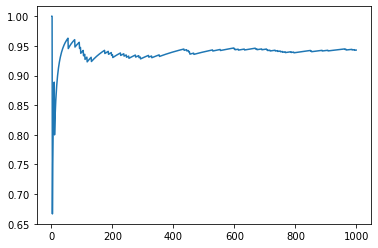

In [25]:
import matplotlib.pyplot as plt
time = [i for i in range(1, nb_iters)]
accuracy = [sum(correctness_dist[:i])/len(correctness_dist[:i]) for i in range(1, nb_iters)]
plt.plot(time, accuracy)

### Alternative Approach with Scikit-Multiflow
In scikit-multiflow, there is a built-in way to do the exact same thing with less code. What we can do is import the EvaluatePrequential class:
We can then set up an “evaluator” as follows

In [28]:
from skmultiflow.evaluation import EvaluatePrequential

evaluator=EvaluatePrequential(show_plot=True,max_samples=nb_iters)


Setting the show_plot=True option will allow a pop up to appear with a real time plot of the classification accuracy.
Now that the evaluator is set up, we can use it to incrementally train our Hoeffding Tree on the SEA data stream, in the same way as before:

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 200 sample(s).
Evaluating...
 ####---------------- [20%] [0.01s]

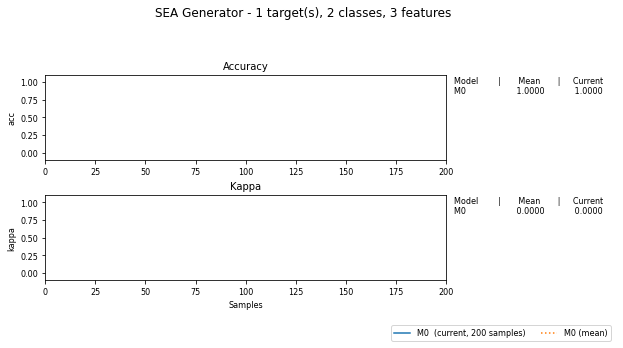

 #################### [100%] [0.39s]
Processed samples: 1000
Mean performance:
M0 - Accuracy     : 0.9263
M0 - Kappa        : 0.8329


[HoeffdingTreeClassifier(binary_split=False, grace_period=200,
                         leaf_prediction='nba', max_byte_size=33554432,
                         memory_estimate_period=1000000, nb_threshold=0,
                         no_preprune=False, nominal_attributes=None,
                         remove_poor_atts=False, split_confidence=1e-07,
                         split_criterion='info_gain', stop_mem_management=False,
                         tie_threshold=0.05)]

In [31]:
evaluator.evaluate(stream=stream, model=tree)
